# Summary:

### Goal: Import other tdata sources for backtest under Dope

Steps:

1. Load the data (this step needs to be replaced by your data source)

2. Data translation

3. Backtest example

In [17]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 16

import dask.dataframe as dd
import pandas as pd
import numpy as np
import time

import plotly.io as pio
pio.renderers.default = 'notebook'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from dope.backengine.backtestdata import DataCollection
from dope.backengine.backtestdata import BacktestData

from dope.backengine.arbengine import ArbBacktester
from dope.backengine.agents.arb import ArbStrategy

from dope.pools.pools import Pool
from dope.backengine.maestro import BackEngineMaestro

# Loading the Data (This step is only an EXAMPLE)

This section will fail in your computer. It is here as an example of loading the data.

In [140]:
from fusiondb.rates.rates import Rates
rates = Rates()
dfs = {
  "base:compound:USDC": rates.get_rates(
    chain_id=8453,
    protocol="compound-v3",
    market_id="0x833589fcd6edb6e08f4c7c32d4f71b54bda02913",
    _from="2025-05-01"
  ).iloc[::10],
  "base:aave-v3:USDC":rates.get_rates(
    chain_id=8453,
    protocol="aave-v3",
    market_id="0x833589fcd6edb6e08f4c7c32d4f71b54bda02913",
    _from="2025-05-01"
  ).iloc[::10],
}

# Due to incentives, we modify the data to highlight the point of this example.
dfs["base:compound:USDC"]["supply_rate"] -= 1

In [141]:
data = DataCollection("data", dfs)

<Axes: xlabel='datetime'>

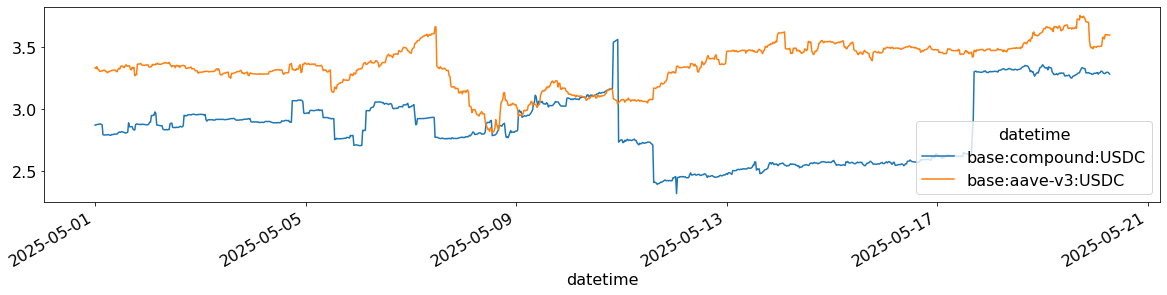

In [142]:
data.as_block().supply_rate.plot()

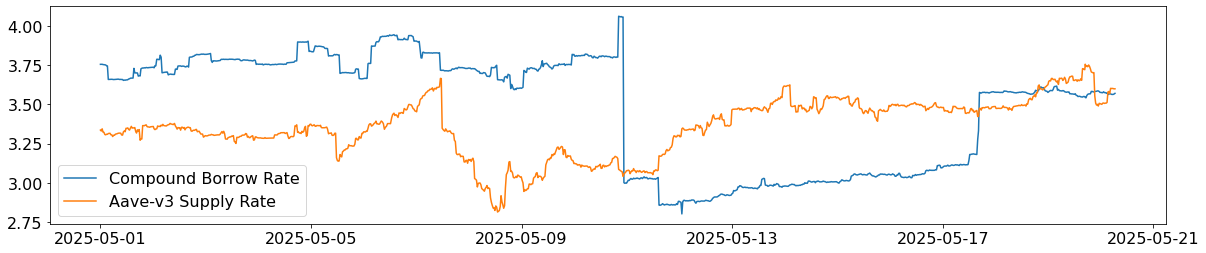

In [169]:
plt.plot(data.as_block().borrow_rate["base:compound:USDC"], label="Compound Borrow Rate")
plt.plot(data.as_block().supply_rate["base:aave-v3:USDC"], label="Aave-v3 Supply Rate")
plt.legend()


In [171]:
# This data format is not recognized by Dope backtest engine:
dfs["base:compound:USDC"].head()

,block_timestamp,block_number,supply_rate,borrow_rate,total_supply,total_borrow
datetime,,,,,,
2025-05-20 06:29:07,1.747723e+09,30466600,3.283908,3.569389,1.945757e+07,1.716772e+07
2025-05-20 06:05:21,1.747721e+09,30465887,3.292355,3.565292,1.945754e+07,1.716609e+07
2025-05-20 05:41:05,1.747720e+09,30465159,3.298178,3.562739,1.945751e+07,1.716601e+07
2025-05-20 05:16:39,1.747718e+09,30464426,3.298757,3.562484,1.945748e+07,1.716598e+07
2025-05-20 04:52:39,1.747717e+09,30463706,3.296778,3.563087,1.945745e+07,1.716495e+07


# Transforming the Data

In [145]:
from dope.backengine.backtestdata import ColumnsTranslation

translation = ColumnsTranslation(
  datetime="index",
  apyBaseBorrow="borrow_rate",
  apyBase="supply_rate",
  totalSupplyUsd="total_supply",
  totalBorrowUsd="total_borrow",
  # utilizationRate=None # In case you have this columns, uncomment this
)

In [147]:
token = "USDC"
run_data = BacktestData({token: data.translate(translation).collection})

In [174]:
# Data is now Dope approved:
run_data[token]["base:compound:USDC"].head()

,block_timestamp,block_number,apyBase,apyBaseBorrow,totalSupplyUsd,totalBorrowUsd,utilizationRate
datetime,,,,,,,
2025-05-01 00:05:19,1.746058e+09,29634286,2.872583,3.754181,2.376611e+07,1.515754e+07,0.637780
2025-05-01 00:29:03,1.746059e+09,29634998,2.876245,3.754262,2.374615e+07,1.515156e+07,0.638064
2025-05-01 00:52:41,1.746061e+09,29635707,2.876229,3.754442,2.374618e+07,1.515209e+07,0.638085
2025-05-01 01:16:39,1.746062e+09,29636426,2.879239,3.752630,2.374621e+07,1.515212e+07,0.638086
2025-05-01 01:40:19,1.746064e+09,29637136,2.880136,3.752092,2.374625e+07,1.515214e+07,0.638086


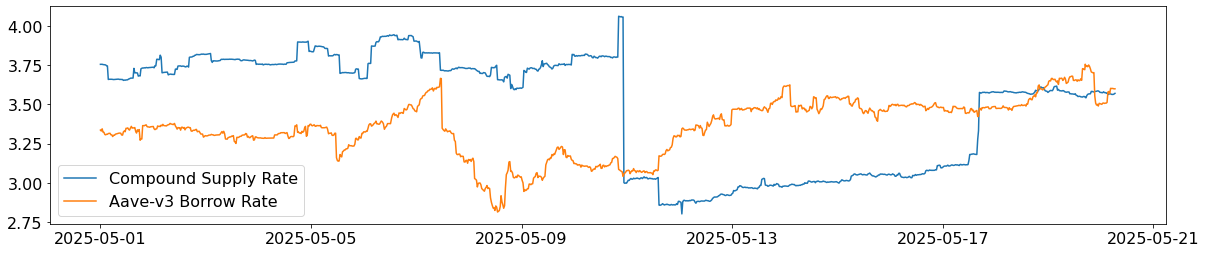

In [148]:
plt.plot(run_data.as_block(token).apyBaseBorrow["base:compound:USDC"], label="Compound Supply Rate")
plt.plot(run_data.as_block(token).apyBase["base:aave-v3:USDC"], label="Aave-v3 Borrow Rate")
plt.legend()


# Backtest

In [168]:
_start_time = "2025-01-24 13:44:00"
_end_time   = "2025-01-24 14:59:00"
summaries = {}



dt = 5
triggers = run_data.as_block(token).utilizationRate.index[::dt//5]
strategy = ArbStrategy(
  token=token, capital=1_000_000, triggers=triggers, 
  past_window_in_minutes=5, profitability_threshold=0)
arbt = ArbBacktester(strategy=strategy, data=run_data, mkt_impact_mode='zero')
summaries[f"arb"], _ = arbt()

Running Backtest for 1,151 | token:USDC


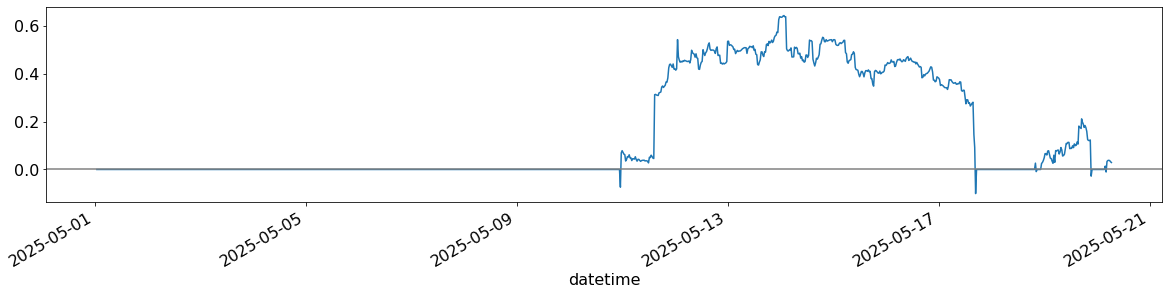

In [163]:
summaries["arb"].rate[:].plot()
plt.axhline(0, color="grey")

In [ ]:
_start_time = "2025-01-24 13:44:00"
_end_time   = "2025-01-24 14:59:00"
summaries = {}



dt = 5
triggers = run_data.as_block(token).utilizationRate.index[::dt//5]
strategy = ArbStrategy(
  token=token, capital=1_000_000, triggers=triggers, 
  past_window_in_minutes=5, profitability_threshold=0)
arbt = ArbBacktester(strategy=strategy, data=run_data, mkt_impact_mode='past')
summaries[f"arb"], _ = arbt()

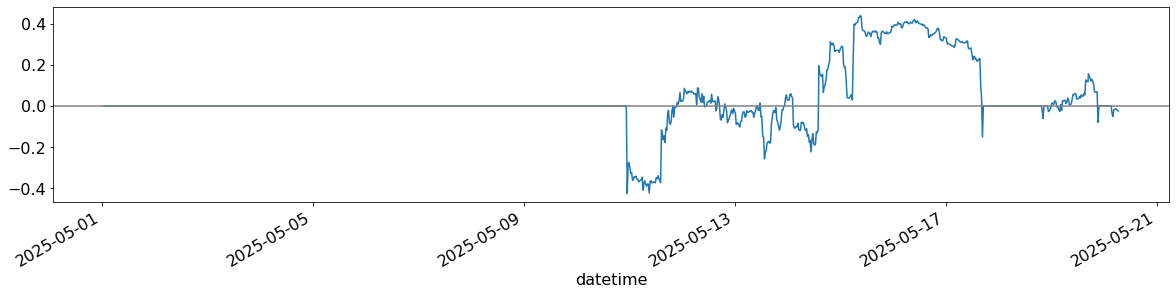

In [166]:
summaries["arb"].rate[:].plot()
plt.axhline(0, color="grey")

In [154]:
from dope.backengine.plotting.arb import Plotter

In [155]:
plotter = Plotter(summaries)

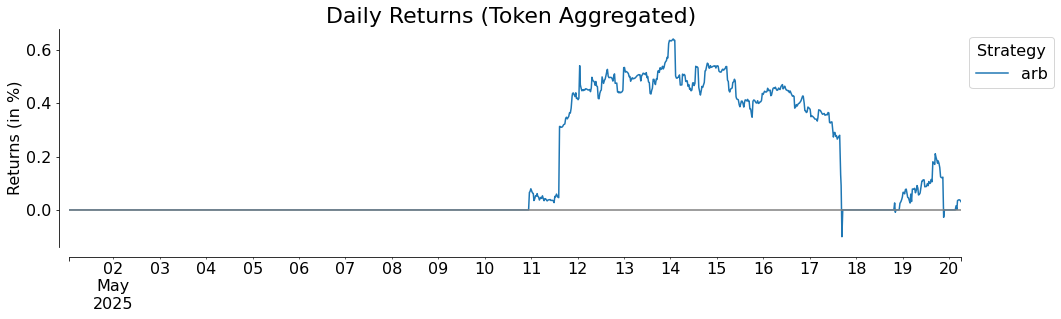

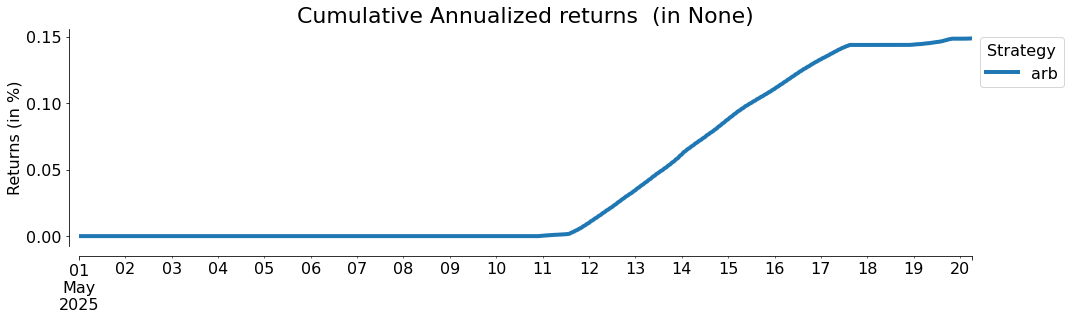

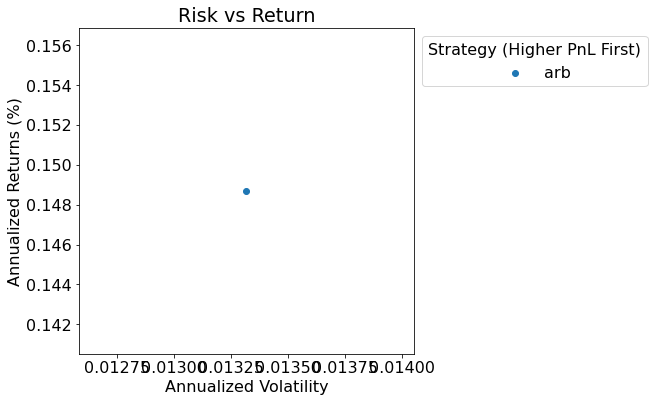

Annualized Returns (base currency):
arb    0.148701
dtype: float64


In [156]:
plotter.summary_view()